In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from keras.preprocessing import image

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


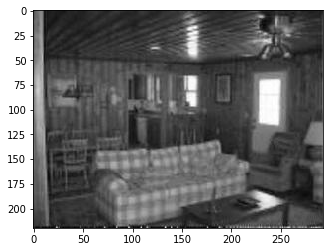

In [2]:
my_class = "livingroom"
y_train = []
listdir02 = os.listdir('./train/{}/'.format(my_class))

im = Image.open("./train/{}/{}".format(my_class,listdir02[0]))
plt.imshow(im)
plt.show()

In [3]:
my_class_dict = {"CALsuburb":9,
"PARoffice":7,
"bedroom":12,
"coast":10,
"forest":4,
"highway":14,
"industrial":2,
"insidecity":3,
"kitchen":0,
"livingroom":5,
"mountain":8,
'opencountry':6,
'store':11,
"street":1,
'tallbuilding':13}

In [4]:
u=128
v=128

def loadImages(key,value):
    whereami_img = []
    labelList = []

    rootdir = r'./train/{}'.format(key)
    lists = os.listdir(rootdir)
    for item in lists:
        path = os.path.join(rootdir,item)
        if(os.path.isfile(path)):
            img = image.load_img(path, target_size=(u, v))
            x = image.img_to_array(img)
            whereami_img.append(x)
            labelList.append(value)
    return whereami_img,labelList

In [5]:
x_train_list = []
y_train_list = []
for i,j in my_class_dict.items():
    ans1,ans2 = loadImages(i,j)
    x_train_list.append(ans1)
    y_train_list.append(ans2)

In [6]:
x_train_list2 = []
for i in x_train_list:
    for j in i:
        x_train_list2.append(j)
        
y_train_list2 = []
for i in y_train_list:
    for j in i:
        y_train_list2.append(j)

x_train = np.array(x_train_list2)
y_train = np.array(y_train_list2)
print(x_train.shape)
print(y_train.shape)

(2985, 128, 128, 3)
(2985,)


In [7]:
from sklearn.model_selection import train_test_split
import keras
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=0.2,)

print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: {}".format(len(x_train)))
print("validation set: {}".format(len(x_valid)))

training set data dimension
(2388, 128, 128, 3)
(2388,)
-----------
training set: 2388
validation set: 597


In [9]:
y_train.shape

(2388,)

In [10]:
batch_size = 128
num_classes = 15
epochs = 40
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_CNN_exam_model.h5'

In [11]:
'''model'''
model = Sequential()
model.add(Conv2D(64,(3,3), padding='same', input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        73792     
__________

In [12]:
# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255.
x_valid /= 255.

In [13]:
def one_hot_encode(x):
    return np.eye(15)[x]

In [14]:
y_train01 = y_train.reshape(1, -1)
y_train01 = one_hot_encode(y_train01)

y_valid01 = y_valid.reshape(1, -1)
y_valid01 = one_hot_encode(y_valid01)

In [15]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [16]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=3)

In [18]:
model_history = model.fit_generator(datagen.flow(x_train, y_train01[0], batch_size=batch_size), \
                          epochs=epochs, \
#                           shuffle=True, \
                          validation_data=(x_valid, y_valid01[0]),\
                          workers=4,\
                          callbacks=[checkpoint, earlystop])

Epoch 1/40
19/19 [==============================] - 12s 642ms/step - loss: 3.0346 - acc: 0.0858 - val_loss: 2.6817 - val_acc: 0.1055

Epoch 00001: val_loss improved from inf to 2.68166, saving model to /home/jovyan/CY_Kaggle/CNN_exam/saved_models/keras_CNN_exam_model.h5
Epoch 2/40
19/19 [==============================] - 5s 256ms/step - loss: 2.6746 - acc: 0.0981 - val_loss: 2.6561 - val_acc: 0.1357

Epoch 00002: val_loss improved from 2.68166 to 2.65607, saving model to /home/jovyan/CY_Kaggle/CNN_exam/saved_models/keras_CNN_exam_model.h5
Epoch 3/40
19/19 [==============================] - 5s 269ms/step - loss: 2.6624 - acc: 0.1060 - val_loss: 2.6412 - val_acc: 0.1357

Epoch 00003: val_loss improved from 2.65607 to 2.64123, saving model to /home/jovyan/CY_Kaggle/CNN_exam/saved_models/keras_CNN_exam_model.h5
Epoch 4/40
19/19 [==============================] - 5s 261ms/step - loss: 2.6402 - acc: 0.1109 - val_loss: 2.6017 - val_acc: 0.1608

Epoch 00004: val_loss improved from 2.64123 to 2

In [19]:
# loading our save model
print("Loading trained model")
model = load_model("./saved_models/{}".format(model_name))

'''prediction'''
y_valid = model.predict_classes(x_valid, batch_size, verbose=0)

Loading trained model


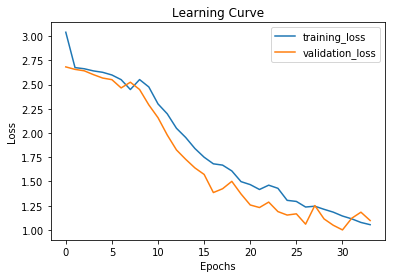

In [20]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [21]:
y_valid[:10]

array([ 1,  5,  2,  0, 12,  3,  6, 14,  3, 13])

In [22]:
import pandas as pd

In [23]:
my_df = pd.read_csv("./img-submission.csv")

In [24]:
x_test_list = []
for i in my_df.id:
    img = image.load_img("./testset/{}.jpg".format(i), target_size=(u, v))
    x_test_list.append(image.img_to_array(img))
x_test = np.array(x_test_list)

In [25]:
# loading our save model
# print("Loading trained model")
# model = load_model("./saved_models/{}".format(model_name))

'''prediction'''
y_test = model.predict_classes(x_test, batch_size, verbose=0)

In [26]:
submission = {
    'ID': my_df.id,
    'class': y_test
}
solution = pd.DataFrame(submission)
solution.head(20)

#make the submission file
solution.to_csv('submission_03.csv',index=False)
solution.head(10)

,ID,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,7
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,10
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...,9
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1...,7
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06d...,2
5,f80823d6bff6c0beba6d55a3157d7a4fa2de4f966351e0...,7
6,3a12151639cf9f8e2af9ea36c2ce6bb15dd8730ea6dc90...,2
7,a5e0980425df5b98864a9580e081a7209e1b6810ed515a...,6
8,d4ea833073c4391387bebaef3c51c22861c1ff108cbb3c...,11
9,013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...,2
